In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from codecarbon import EmissionsTracker
import pynvml

In [2]:
cudnn.benchmark = True
plt.ion()  # interactive mode

### Data augmentation and normalization for training

In [3]:
input_path = "../dataset/"

In [4]:
# Data augmentation and normalization for training using torchvision transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(input_path, 'train'), data_transforms['train']),
    'validation': datasets.ImageFolder(os.path.join(input_path, 'validation'), data_transforms['validation']),
    'test': datasets.ImageFolder(os.path.join(input_path, 'test'), data_transforms['test'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True, num_workers=4)
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Compute class weights


In [8]:
labels = np.array([s[1] for s in image_datasets['train'].samples])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [9]:
class_weights

tensor([0.8391, 2.2476, 0.8502, 0.8424], device='cuda:0')

In [10]:
class_names

['e', 'm', 's', 'sb']

### Training the model




In [11]:
# Initialize NVML
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

In [13]:
# Definir la ruta de la carpeta "revision"
output_dir = "revision/101_20ep"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [14]:
output_dir

'revision/101_20ep'

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    results = []
    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            phase_preds = []
            phase_labels = []
            energy_consumed = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Measure energy consumption before forward pass
                energy_before = pynvml.nvmlDeviceGetTotalEnergyConsumption(handle)

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Measure energy consumption after forward pass
                energy_after = pynvml.nvmlDeviceGetTotalEnergyConsumption(handle)
                energy_consumed += energy_after - energy_before

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                phase_labels.extend(labels.cpu().numpy())
                phase_preds.extend(preds.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Additional metrics
            precision, recall, f1, _ = precision_recall_fscore_support(phase_labels, phase_preds, average='weighted')
            cm = confusion_matrix(phase_labels, phase_preds)
            acc = accuracy_score(phase_labels, phase_preds)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')
            print(f'Confusion Matrix:\n{cm}')
            print(f'Energy consumed: {energy_consumed} mJ')

            # Save results
            results.append([epoch, phase, epoch_loss, epoch_acc, precision, recall, f1, energy_consumed])

            # Save all predictions and labels for the validation phase
            if phase == 'validation':
                all_preds.extend(phase_preds)
                all_labels.extend(phase_labels)

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # Save the best model
    best_model_path = os.path.join(output_dir, 'best_model.pth')
    torch.save(model.state_dict(), best_model_path)
    print(f'Best model weights saved at {best_model_path}')

    # Save the entire best model
    full_best_model_path = os.path.join(output_dir, 'full_best_model.pth')
    torch.save(model, full_best_model_path)
    print(f'Full best model saved at {full_best_model_path}')
    
    # Save results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Epoch', 'Phase', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Energy Consumed (mJ)'])
    results_df.to_csv('training_results.csv', index=False)
    print("Training results saved to 'training_results.csv'")

    return model, all_labels, all_preds


In [16]:
# Finetuning the convnet
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)  # Añadir weight_decay para L2 Regularization
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=10)

# Initialize EmissionsTracker
tracker = EmissionsTracker()
tracker.start()



[codecarbon INFO @ 13:42:05] [setup] RAM Tracking...
[codecarbon INFO @ 13:42:05] [setup] GPU Tracking...
[codecarbon INFO @ 13:42:05] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:42:05] [setup] CPU Tracking...
[codecarbon WARNING @ 13:42:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:42:06] We saw that you have a Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 13:42:06] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
[codecarbon INFO @ 13:42:06] >>> Tracker's metadata:
[codecarbon INFO @ 13:42:06]   Platform system: Linux-5.4.0-1103-aws-x86_64-with-debian-buster-sid
[codecarbon INFO @ 13:42:06]   Python version: 3.6.13
[codecarbon INFO @ 13:42:06]   CodeCarbon version: 2.2.6
[codecarbon INFO @ 13:42:06]   Available RAM : 59.859 GB
[codecarbon INFO @ 13:42:06]   CPU count: 8
[codecarbon INFO @ 13:42:06]   CPU model: Intel(R) Xeon(R) CPU E5-2686 v4

In [17]:
%%time
model_ft, all_labels, all_preds = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

# Stop EmissionsTracker and get CO2 emissions
emissions = tracker.stop()
print(f'CO2 emissions: {emissions} kg')

Epoch 0/19
----------


[codecarbon INFO @ 13:42:22] Energy consumed for RAM : 0.000094 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:42:22] Energy consumed for all GPUs : 0.000937 kWh. Total GPU Power : 224.90800000000002 W
[codecarbon INFO @ 13:42:22] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:42:22] 0.001208 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:42:37] Energy consumed for RAM : 0.000187 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:42:37] Energy consumed for all GPUs : 0.001336 kWh. Total GPU Power : 95.607 W
[codecarbon INFO @ 13:42:37] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:42:37] 0.001877 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:42:52] Energy consumed for RAM : 0.000280 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:42:52] Energy consumed for all GPUs : 0.002332 kWh. Total GPU Power : 239.274 W
[codecarbon IN

train Loss: 1.1154 Acc: 0.4898 Precision: 0.5066 Recall: 0.4898 F1: 0.4938
Confusion Matrix:
[[2094  502  653  367]
 [ 223  714  214  199]
 [ 699  577 1443  850]
 [ 455  523  930 1694]]
Energy consumed: 14067901 mJ


[codecarbon INFO @ 13:43:22] Energy consumed for RAM : 0.000467 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:43:22] Energy consumed for all GPUs : 0.003602 kWh. Total GPU Power : 94.71600000000001 W
[codecarbon INFO @ 13:43:22] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:43:22] 0.004955 kWh of electricity used since the beginning.


validation Loss: 0.8965 Acc: 0.5697 Precision: 0.6576 Recall: 0.5697 F1: 0.5607
Confusion Matrix:
[[367 303 454  86]
 [  6 360  19  30]
 [ 37 185 711 298]
 [  8 132 183 867]]
Energy consumed: 467497 mJ

Epoch 1/19
----------


[codecarbon INFO @ 13:43:37] Energy consumed for RAM : 0.000561 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:43:37] Energy consumed for all GPUs : 0.004670 kWh. Total GPU Power : 256.4630000000001 W
[codecarbon INFO @ 13:43:37] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:43:37] 0.006293 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:43:52] Energy consumed for RAM : 0.000654 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:43:52] Energy consumed for all GPUs : 0.005725 kWh. Total GPU Power : 253.323 W
[codecarbon INFO @ 13:43:52] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:43:52] 0.007619 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:44:07] Energy consumed for RAM : 0.000748 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:44:07] Energy consumed for all GPUs : 0.006751 kWh. Total GPU Power : 246.33500000000004 W
[co

train Loss: 0.8819 Acc: 0.6219 Precision: 0.6378 Recall: 0.6219 F1: 0.6248
Confusion Matrix:
[[2512  396  521  187]
 [ 135  954  124  137]
 [ 593  483 1913  580]
 [ 338  359  736 2169]]
Energy consumed: 14301127 mJ
validation Loss: 0.7325 Acc: 0.6822 Precision: 0.7208 Recall: 0.6822 F1: 0.6869
Confusion Matrix:
[[939 126 121  24]
 [ 29 355  19  12]
 [237 170 754  70]
 [ 84 149 245 712]]
Energy consumed: 576804 mJ

Epoch 2/19
----------


[codecarbon INFO @ 13:44:52] Energy consumed for RAM : 0.001028 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:44:52] Energy consumed for all GPUs : 0.009858 kWh. Total GPU Power : 249.368 W
[codecarbon INFO @ 13:44:52] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:44:52] 0.012834 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:45:07] Energy consumed for RAM : 0.001122 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:45:07] Energy consumed for all GPUs : 0.010925 kWh. Total GPU Power : 256.414 W
[codecarbon INFO @ 13:45:07] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:45:07] 0.014172 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:45:22] Energy consumed for RAM : 0.001215 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:45:22] Energy consumed for all GPUs : 0.011896 kWh. Total GPU Power : 232.972 W
[codecarbon INFO @ 13:45

train Loss: 0.8088 Acc: 0.6539 Precision: 0.6680 Recall: 0.6539 F1: 0.6561
Confusion Matrix:
[[2610  354  500  152]
 [ 114 1003  117  116]
 [ 626  457 1963  523]
 [ 284  322  636 2360]]
Energy consumed: 14514582 mJ
validation Loss: 0.7492 Acc: 0.6935 Precision: 0.7231 Recall: 0.6935 F1: 0.6957
Confusion Matrix:
[[958 108 142   2]
 [ 32 338  29  16]
 [242 131 792  66]
 [131  79 262 718]]
Energy consumed: 571462 mJ

Epoch 3/19
----------


[codecarbon INFO @ 13:46:07] Energy consumed for RAM : 0.001496 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:46:07] Energy consumed for all GPUs : 0.014975 kWh. Total GPU Power : 228.228 W
[codecarbon INFO @ 13:46:07] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:46:07] 0.019304 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:22] Energy consumed for RAM : 0.001589 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:46:22] Energy consumed for all GPUs : 0.016026 kWh. Total GPU Power : 252.33700000000005 W
[codecarbon INFO @ 13:46:22] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:46:22] 0.020625 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:37] Energy consumed for RAM : 0.001682 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:46:37] Energy consumed for all GPUs : 0.016887 kWh. Total GPU Power : 206.88700000000003 W
[c

train Loss: 0.7550 Acc: 0.6811 Precision: 0.6954 Recall: 0.6811 F1: 0.6837
Confusion Matrix:
[[2647  335  487  147]
 [ 113 1038  111   88]
 [ 568  419 2134  448]
 [ 266  293  596 2447]]
Energy consumed: 14536351 mJ
validation Loss: 0.6604 Acc: 0.7341 Precision: 0.7478 Recall: 0.7341 F1: 0.7370
Confusion Matrix:
[[943  87 159  21]
 [ 29 334  24  28]
 [179 136 812 104]
 [ 59  62 188 881]]
Energy consumed: 560340 mJ

Epoch 4/19
----------


[codecarbon INFO @ 13:47:22] Energy consumed for RAM : 0.001963 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:47:22] Energy consumed for all GPUs : 0.019887 kWh. Total GPU Power : 253.92600000000004 W
[codecarbon INFO @ 13:47:22] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:47:22] 0.025568 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:37] Energy consumed for RAM : 0.002056 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:47:37] Energy consumed for all GPUs : 0.020848 kWh. Total GPU Power : 230.762 W
[codecarbon INFO @ 13:47:37] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:47:37] 0.026800 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:52] Energy consumed for RAM : 0.002150 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:47:52] Energy consumed for all GPUs : 0.021845 kWh. Total GPU Power : 239.436 W
[codecarbon I

train Loss: 0.7223 Acc: 0.6946 Precision: 0.7073 Recall: 0.6946 F1: 0.6967
Confusion Matrix:
[[2676  309  505  126]
 [ 114 1075   89   72]
 [ 574  388 2179  428]
 [ 224  259  619 2500]]
Energy consumed: 14609511 mJ


[codecarbon INFO @ 13:48:22] Energy consumed for RAM : 0.002337 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:48:22] Energy consumed for all GPUs : 0.023154 kWh. Total GPU Power : 57.566 W
[codecarbon INFO @ 13:48:22] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:48:22] 0.029918 kWh of electricity used since the beginning.


validation Loss: 0.6732 Acc: 0.7360 Precision: 0.7536 Recall: 0.7360 F1: 0.7303
Confusion Matrix:
[[1089   62   52    7]
 [  46  313   23   33]
 [ 363  104  638  126]
 [ 107   49   96  938]]
Energy consumed: 572405 mJ

Epoch 5/19
----------


[codecarbon INFO @ 13:48:37] Energy consumed for RAM : 0.002430 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:48:37] Energy consumed for all GPUs : 0.024218 kWh. Total GPU Power : 255.47000000000003 W
[codecarbon INFO @ 13:48:37] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:48:37] 0.031252 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:48:52] Energy consumed for RAM : 0.002524 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:48:52] Energy consumed for all GPUs : 0.025271 kWh. Total GPU Power : 252.809 W
[codecarbon INFO @ 13:48:52] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:48:52] 0.032575 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:49:07] Energy consumed for RAM : 0.002617 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:49:07] Energy consumed for all GPUs : 0.026314 kWh. Total GPU Power : 250.61700000000005 W
[c

train Loss: 0.6893 Acc: 0.7121 Precision: 0.7224 Recall: 0.7121 F1: 0.7134
Confusion Matrix:
[[2763  277  465  111]
 [  94 1101   75   80]
 [ 598  358 2227  386]
 [ 252  218  580 2552]]
Energy consumed: 14612281 mJ


[codecarbon INFO @ 13:49:37] Energy consumed for RAM : 0.002804 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:49:37] Energy consumed for all GPUs : 0.027807 kWh. Total GPU Power : 118.763 W
[codecarbon INFO @ 13:49:37] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:49:37] 0.035923 kWh of electricity used since the beginning.


validation Loss: 0.6547 Acc: 0.7444 Precision: 0.7528 Recall: 0.7444 F1: 0.7437
Confusion Matrix:
[[ 930  109  119   52]
 [  25  314   24   52]
 [ 201  107  752  171]
 [  52   43   79 1016]]
Energy consumed: 601526 mJ

Epoch 6/19
----------


[codecarbon INFO @ 13:49:52] Energy consumed for RAM : 0.002898 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:49:52] Energy consumed for all GPUs : 0.028713 kWh. Total GPU Power : 217.648 W
[codecarbon INFO @ 13:49:52] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:49:52] 0.037100 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:50:07] Energy consumed for RAM : 0.002991 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:50:07] Energy consumed for all GPUs : 0.029651 kWh. Total GPU Power : 225.26200000000003 W
[codecarbon INFO @ 13:50:07] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:50:07] 0.038308 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:50:22] Energy consumed for RAM : 0.003084 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:50:22] Energy consumed for all GPUs : 0.030728 kWh. Total GPU Power : 258.599 W
[codecarbon I

train Loss: 0.6595 Acc: 0.7239 Precision: 0.7336 Recall: 0.7239 F1: 0.7254
Confusion Matrix:
[[2764  261  462  129]
 [  90 1108   85   67]
 [ 550  343 2312  364]
 [ 239  205  556 2602]]
Energy consumed: 14656143 mJ


[codecarbon INFO @ 13:50:52] Energy consumed for RAM : 0.003271 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:50:52] Energy consumed for all GPUs : 0.032747 kWh. Total GPU Power : 230.132 W
[codecarbon INFO @ 13:50:52] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:50:52] 0.042216 kWh of electricity used since the beginning.


validation Loss: 0.6270 Acc: 0.7304 Precision: 0.7514 Recall: 0.7304 F1: 0.7335
Confusion Matrix:
[[877 149 135  49]
 [ 15 361  12  27]
 [173 148 763 147]
 [ 37  75 124 954]]
Energy consumed: 624841 mJ

Epoch 7/19
----------


[codecarbon INFO @ 13:51:07] Energy consumed for RAM : 0.003365 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:51:07] Energy consumed for all GPUs : 0.033592 kWh. Total GPU Power : 202.881 W
[codecarbon INFO @ 13:51:07] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:51:07] 0.043331 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:22] Energy consumed for RAM : 0.003458 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:51:22] Energy consumed for all GPUs : 0.034618 kWh. Total GPU Power : 246.364 W
[codecarbon INFO @ 13:51:22] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:51:22] 0.044628 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:37] Energy consumed for RAM : 0.003552 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:51:37] Energy consumed for all GPUs : 0.035672 kWh. Total GPU Power : 253.15200000000004 W
[codecarbon I

train Loss: 0.6496 Acc: 0.7274 Precision: 0.7376 Recall: 0.7274 F1: 0.7290
Confusion Matrix:
[[2783  291  416  126]
 [  78 1105   84   83]
 [ 561  365 2275  368]
 [ 211  199  526 2666]]
Energy consumed: 14685675 mJ


[codecarbon INFO @ 13:52:07] Energy consumed for RAM : 0.003739 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:52:07] Energy consumed for all GPUs : 0.037789 kWh. Total GPU Power : 246.697 W
[codecarbon INFO @ 13:52:07] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:52:07] 0.048610 kWh of electricity used since the beginning.


validation Loss: 0.5889 Acc: 0.7546 Precision: 0.7686 Recall: 0.7546 F1: 0.7566
Confusion Matrix:
[[926 114 128  42]
 [ 15 353  19  28]
 [183 125 800 123]
 [ 42  65 109 974]]
Energy consumed: 570573 mJ

Epoch 8/19
----------


[codecarbon INFO @ 13:52:22] Energy consumed for RAM : 0.003832 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:52:22] Energy consumed for all GPUs : 0.038480 kWh. Total GPU Power : 165.964 W
[codecarbon INFO @ 13:52:22] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:52:22] 0.049572 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:52:37] Energy consumed for RAM : 0.003926 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:52:37] Energy consumed for all GPUs : 0.039487 kWh. Total GPU Power : 241.80100000000002 W
[codecarbon INFO @ 13:52:37] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:52:37] 0.050849 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:52:52] Energy consumed for RAM : 0.004019 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:52:52] Energy consumed for all GPUs : 0.039893 kWh. Total GPU Power : 97.58200000000002 W
[co

train Loss: 0.6478 Acc: 0.7265 Precision: 0.7381 Recall: 0.7265 F1: 0.7289
Confusion Matrix:
[[2784  284  450   98]
 [  85 1075  114   76]
 [ 536  364 2317  352]
 [ 202  212  546 2642]]
Energy consumed: 14675592 mJ


[codecarbon INFO @ 13:53:22] Energy consumed for RAM : 0.004206 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:53:22] Energy consumed for all GPUs : 0.041495 kWh. Total GPU Power : 146.497 W
[codecarbon INFO @ 13:53:22] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:53:22] 0.053669 kWh of electricity used since the beginning.


validation Loss: 0.5850 Acc: 0.7687 Precision: 0.7771 Recall: 0.7687 F1: 0.7701
Confusion Matrix:
[[973  82 125  30]
 [ 30 330  22  33]
 [194 106 831 100]
 [ 46  56 112 976]]
Energy consumed: 591291 mJ

Epoch 9/19
----------


[codecarbon INFO @ 13:53:37] Energy consumed for RAM : 0.004299 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:53:37] Energy consumed for all GPUs : 0.042569 kWh. Total GPU Power : 258.005 W
[codecarbon INFO @ 13:53:37] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:53:37] 0.055014 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:53:52] Energy consumed for RAM : 0.004393 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:53:52] Energy consumed for all GPUs : 0.043602 kWh. Total GPU Power : 247.94900000000004 W
[codecarbon INFO @ 13:53:52] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:53:52] 0.056317 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:54:07] Energy consumed for RAM : 0.004486 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:54:07] Energy consumed for all GPUs : 0.044687 kWh. Total GPU Power : 260.543 W
[codecarbon I

train Loss: 0.6144 Acc: 0.7458 Precision: 0.7560 Recall: 0.7458 F1: 0.7475
Confusion Matrix:
[[2860  247  416   93]
 [  89 1119   79   63]
 [ 537  341 2389  302]
 [ 220  185  513 2684]]
Energy consumed: 14703138 mJ


[codecarbon INFO @ 13:54:37] Energy consumed for RAM : 0.004673 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:54:37] Energy consumed for all GPUs : 0.046033 kWh. Total GPU Power : 58.006 W
[codecarbon INFO @ 13:54:37] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:54:37] 0.059559 kWh of electricity used since the beginning.


validation Loss: 0.5854 Acc: 0.7711 Precision: 0.7795 Recall: 0.7711 F1: 0.7730
Confusion Matrix:
[[954  86 142  28]
 [ 27 331  24  33]
 [179 101 856  95]
 [ 41  54 116 979]]
Energy consumed: 561851 mJ

Epoch 10/19
----------


[codecarbon INFO @ 13:54:52] Energy consumed for RAM : 0.004767 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:54:52] Energy consumed for all GPUs : 0.047088 kWh. Total GPU Power : 253.58199999999997 W
[codecarbon INFO @ 13:54:52] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:54:52] 0.060886 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:07] Energy consumed for RAM : 0.004860 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:55:07] Energy consumed for all GPUs : 0.047992 kWh. Total GPU Power : 216.88100000000003 W
[codecarbon INFO @ 13:55:07] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:55:07] 0.062059 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:22] Energy consumed for RAM : 0.004954 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:55:22] Energy consumed for all GPUs : 0.048925 kWh. Total GPU Power : 224.26200000

train Loss: 0.6136 Acc: 0.7395 Precision: 0.7499 Recall: 0.7395 F1: 0.7411
Confusion Matrix:
[[2780  275  441  120]
 [  75 1145   73   57]
 [ 502  348 2372  347]
 [ 210  185  529 2678]]
Energy consumed: 14681265 mJ


[codecarbon INFO @ 13:55:52] Energy consumed for RAM : 0.005141 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:55:52] Energy consumed for all GPUs : 0.050129 kWh. Total GPU Power : 93.69800000000001 W
[codecarbon INFO @ 13:55:52] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:55:52] 0.065008 kWh of electricity used since the beginning.


validation Loss: 0.5795 Acc: 0.7684 Precision: 0.7808 Recall: 0.7684 F1: 0.7709
Confusion Matrix:
[[971  95 124  20]
 [ 25 341  23  26]
 [202 109 839  81]
 [ 48  62 122 958]]
Energy consumed: 617405 mJ

Epoch 11/19
----------


[codecarbon INFO @ 13:56:07] Energy consumed for RAM : 0.005234 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:56:07] Energy consumed for all GPUs : 0.051199 kWh. Total GPU Power : 257.184 W
[codecarbon INFO @ 13:56:07] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:56:07] 0.066349 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:22] Energy consumed for RAM : 0.005327 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:56:22] Energy consumed for all GPUs : 0.052238 kWh. Total GPU Power : 249.368 W
[codecarbon INFO @ 13:56:22] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:56:22] 0.067658 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:56:37] Energy consumed for RAM : 0.005421 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:56:37] Energy consumed for all GPUs : 0.053293 kWh. Total GPU Power : 253.41000000000003 W
[codecarbon I

train Loss: 0.6169 Acc: 0.7392 Precision: 0.7489 Recall: 0.7392 F1: 0.7407
Confusion Matrix:
[[2830  257  427  102]
 [  68 1121  101   60]
 [ 542  332 2360  335]
 [ 219  184  538 2661]]
Energy consumed: 14711586 mJ


[codecarbon INFO @ 13:57:07] Energy consumed for RAM : 0.005608 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:57:07] Energy consumed for all GPUs : 0.055118 kWh. Total GPU Power : 179.502 W
[codecarbon INFO @ 13:57:07] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:57:07] 0.071350 kWh of electricity used since the beginning.


validation Loss: 0.5911 Acc: 0.7664 Precision: 0.7750 Recall: 0.7664 F1: 0.7679
Confusion Matrix:
[[ 933   96  146   35]
 [  23  332   25   35]
 [ 171  105  836  119]
 [  39   53   98 1000]]
Energy consumed: 578447 mJ

Epoch 12/19
----------


[codecarbon INFO @ 13:57:22] Energy consumed for RAM : 0.005701 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:57:22] Energy consumed for all GPUs : 0.056149 kWh. Total GPU Power : 247.476 W
[codecarbon INFO @ 13:57:22] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:57:22] 0.072651 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:57:37] Energy consumed for RAM : 0.005795 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:57:37] Energy consumed for all GPUs : 0.056801 kWh. Total GPU Power : 156.67000000000004 W
[codecarbon INFO @ 13:57:37] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:57:37] 0.073574 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:57:52] Energy consumed for RAM : 0.005888 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:57:52] Energy consumed for all GPUs : 0.057678 kWh. Total GPU Power : 210.53900000000004 W
[c

train Loss: 0.6214 Acc: 0.7430 Precision: 0.7538 Recall: 0.7430 F1: 0.7452
Confusion Matrix:
[[2795  268  466   87]
 [  96 1105   85   64]
 [ 522  321 2421  305]
 [ 205  194  506 2697]]
Energy consumed: 14692865 mJ


[codecarbon INFO @ 13:58:22] Energy consumed for RAM : 0.006075 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:58:22] Energy consumed for all GPUs : 0.059084 kWh. Total GPU Power : 115.982 W
[codecarbon INFO @ 13:58:22] Energy consumed for all CPUs : 0.011509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:58:22] 0.076668 kWh of electricity used since the beginning.


validation Loss: 0.5784 Acc: 0.7662 Precision: 0.7792 Recall: 0.7662 F1: 0.7691
Confusion Matrix:
[[929 103 154  24]
 [ 20 347  19  29]
 [166 115 854  96]
 [ 38  62 120 970]]
Energy consumed: 517426 mJ

Epoch 13/19
----------


[codecarbon INFO @ 13:58:37] Energy consumed for RAM : 0.006169 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:58:37] Energy consumed for all GPUs : 0.060171 kWh. Total GPU Power : 261.074 W
[codecarbon INFO @ 13:58:37] Energy consumed for all CPUs : 0.011686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:58:37] 0.078026 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:58:52] Energy consumed for RAM : 0.006262 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:58:52] Energy consumed for all GPUs : 0.061075 kWh. Total GPU Power : 217.174 W
[codecarbon INFO @ 13:58:52] Energy consumed for all CPUs : 0.011863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:58:52] 0.079201 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:07] Energy consumed for RAM : 0.006356 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:59:07] Energy consumed for all GPUs : 0.062136 kWh. Total GPU Power : 254.699 W
[codecarbon INFO @ 13:59

train Loss: 0.6289 Acc: 0.7370 Precision: 0.7478 Recall: 0.7370 F1: 0.7389
Confusion Matrix:
[[2802  258  450  106]
 [  78 1121   88   63]
 [ 525  360 2355  329]
 [ 200  192  543 2667]]
Energy consumed: 14714347 mJ
validation Loss: 0.5805 Acc: 0.7654 Precision: 0.7765 Recall: 0.7654 F1: 0.7683
Confusion Matrix:
[[911  87 192  20]
 [ 27 336  22  30]
 [151 103 881  96]
 [ 38  63 120 969]]
Energy consumed: 561698 mJ

Epoch 14/19
----------


[codecarbon INFO @ 13:59:37] Energy consumed for RAM : 0.006543 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:59:37] Energy consumed for all GPUs : 0.063483 kWh. Total GPU Power : 56.571 W
[codecarbon INFO @ 13:59:37] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:59:37] 0.082420 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:52] Energy consumed for RAM : 0.006636 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 13:59:52] Energy consumed for all GPUs : 0.064438 kWh. Total GPU Power : 229.48600000000002 W
[codecarbon INFO @ 13:59:52] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:59:52] 0.083646 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:00:07] Energy consumed for RAM : 0.006729 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:00:07] Energy consumed for all GPUs : 0.065557 kWh. Total GPU Power : 268.65 W
[codecarbon INF

train Loss: 0.6442 Acc: 0.7293 Precision: 0.7405 Recall: 0.7293 F1: 0.7315
Confusion Matrix:
[[2744  296  466  110]
 [  94 1103   95   58]
 [ 525  358 2322  364]
 [ 197  199  523 2683]]
Energy consumed: 14698902 mJ
validation Loss: 0.6037 Acc: 0.7477 Precision: 0.7684 Recall: 0.7477 F1: 0.7518
Confusion Matrix:
[[846 110 231  23]
 [ 20 356  18  21]
 [107 138 863 123]
 [ 32  72 126 960]]
Energy consumed: 581899 mJ

Epoch 15/19
----------


[codecarbon INFO @ 14:00:52] Energy consumed for RAM : 0.007010 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:00:52] Energy consumed for all GPUs : 0.068484 kWh. Total GPU Power : 234.70600000000002 W
[codecarbon INFO @ 14:00:52] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:00:52] 0.088774 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:01:07] Energy consumed for RAM : 0.007103 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:01:07] Energy consumed for all GPUs : 0.069203 kWh. Total GPU Power : 172.849 W
[codecarbon INFO @ 14:01:07] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:01:07] 0.089764 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:01:22] Energy consumed for RAM : 0.007197 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:01:22] Energy consumed for all GPUs : 0.070252 kWh. Total GPU Power : 251.865 W
[codecarbon I

train Loss: 0.6452 Acc: 0.7274 Precision: 0.7372 Recall: 0.7274 F1: 0.7290
Confusion Matrix:
[[2776  271  463  106]
 [  74 1111   93   72]
 [ 534  340 2307  388]
 [ 204  204  559 2635]]
Energy consumed: 14736024 mJ
validation Loss: 0.6624 Acc: 0.7308 Precision: 0.7462 Recall: 0.7308 F1: 0.7300
Confusion Matrix:
[[914 121 128  47]
 [ 17 343  22  33]
 [166 128 701 236]
 [ 46  71  74 999]]
Energy consumed: 593832 mJ

Epoch 16/19
----------


[codecarbon INFO @ 14:02:07] Energy consumed for RAM : 0.007477 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:02:07] Energy consumed for all GPUs : 0.073364 kWh. Total GPU Power : 242.747 W
[codecarbon INFO @ 14:02:07] Energy consumed for all CPUs : 0.014165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:02:07] 0.095007 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:02:22] Energy consumed for RAM : 0.007571 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:02:22] Energy consumed for all GPUs : 0.074261 kWh. Total GPU Power : 215.461 W
[codecarbon INFO @ 14:02:22] Energy consumed for all CPUs : 0.014342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:02:22] 0.096174 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:02:37] Energy consumed for RAM : 0.007664 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:02:37] Energy consumed for all GPUs : 0.075356 kWh. Total GPU Power : 262.906 W
[codecarbon INFO @ 14:02

train Loss: 0.6732 Acc: 0.7190 Precision: 0.7321 Recall: 0.7190 F1: 0.7214
Confusion Matrix:
[[2721  289  486  120]
 [  96 1103   81   70]
 [ 540  368 2294  367]
 [ 204  264  525 2609]]
Energy consumed: 14683448 mJ
validation Loss: 0.6299 Acc: 0.7561 Precision: 0.7741 Recall: 0.7561 F1: 0.7607
Confusion Matrix:
[[899  77 217  17]
 [ 35 336  24  20]
 [130 132 891  78]
 [ 34  75 148 933]]
Energy consumed: 634560 mJ

Epoch 17/19
----------


[codecarbon INFO @ 14:03:22] Energy consumed for RAM : 0.007945 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:03:22] Energy consumed for all GPUs : 0.077161 kWh. Total GPU Power : 108.90300000000002 W
[codecarbon INFO @ 14:03:22] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:03:22] 0.100156 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:03:37] Energy consumed for RAM : 0.008038 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:03:37] Energy consumed for all GPUs : 0.078243 kWh. Total GPU Power : 259.894 W
[codecarbon INFO @ 14:03:37] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:03:37] 0.101508 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:03:52] Energy consumed for RAM : 0.008131 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:03:52] Energy consumed for all GPUs : 0.078732 kWh. Total GPU Power : 117.491 W
[codecarbon I

train Loss: 0.6844 Acc: 0.7162 Precision: 0.7281 Recall: 0.7162 F1: 0.7183
Confusion Matrix:
[[2749  278  474  115]
 [ 111 1083   89   67]
 [ 542  372 2289  366]
 [ 229  229  573 2571]]
Energy consumed: 14697464 mJ


[codecarbon INFO @ 14:04:22] Energy consumed for RAM : 0.008318 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:04:22] Energy consumed for all GPUs : 0.080397 kWh. Total GPU Power : 177.249 W
[codecarbon INFO @ 14:04:22] Energy consumed for all CPUs : 0.015759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:04:22] 0.104474 kWh of electricity used since the beginning.


validation Loss: 0.7896 Acc: 0.6893 Precision: 0.7354 Recall: 0.6893 F1: 0.6861
Confusion Matrix:
[[1024   40  145    1]
 [  63  261   77   14]
 [ 212   84  920   15]
 [  97   54  455  584]]
Energy consumed: 633501 mJ

Epoch 18/19
----------


[codecarbon INFO @ 14:04:37] Energy consumed for RAM : 0.008412 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:04:37] Energy consumed for all GPUs : 0.081507 kWh. Total GPU Power : 266.755 W
[codecarbon INFO @ 14:04:37] Energy consumed for all CPUs : 0.015936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:04:37] 0.105855 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:52] Energy consumed for RAM : 0.008505 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:04:52] Energy consumed for all GPUs : 0.082589 kWh. Total GPU Power : 259.894 W
[codecarbon INFO @ 14:04:52] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:04:52] 0.107208 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:05:07] Energy consumed for RAM : 0.008599 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:05:07] Energy consumed for all GPUs : 0.083653 kWh. Total GPU Power : 255.297 W
[codecarbon INFO @ 14:05

train Loss: 0.6826 Acc: 0.7109 Precision: 0.7219 Recall: 0.7109 F1: 0.7127
Confusion Matrix:
[[2733  267  496  120]
 [ 105 1087   90   68]
 [ 527  352 2284  406]
 [ 231  239  608 2524]]
Energy consumed: 14673074 mJ


[codecarbon INFO @ 14:05:37] Energy consumed for RAM : 0.008786 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:05:37] Energy consumed for all GPUs : 0.085405 kWh. Total GPU Power : 157.252 W
[codecarbon INFO @ 14:05:37] Energy consumed for all CPUs : 0.016644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:05:37] 0.110834 kWh of electricity used since the beginning.


validation Loss: 0.6417 Acc: 0.7548 Precision: 0.7654 Recall: 0.7548 F1: 0.7553
Confusion Matrix:
[[1047   58   97    8]
 [  45  300   32   38]
 [ 253  103  800   75]
 [  86   57  140  907]]
Energy consumed: 538338 mJ

Epoch 19/19
----------


[codecarbon INFO @ 14:05:52] Energy consumed for RAM : 0.008879 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:05:52] Energy consumed for all GPUs : 0.086446 kWh. Total GPU Power : 250.145 W
[codecarbon INFO @ 14:05:52] Energy consumed for all CPUs : 0.016821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:05:52] 0.112146 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:06:07] Energy consumed for RAM : 0.008973 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:06:07] Energy consumed for all GPUs : 0.087494 kWh. Total GPU Power : 251.73299999999998 W
[codecarbon INFO @ 14:06:07] Energy consumed for all CPUs : 0.016998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:06:07] 0.113465 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:06:22] Energy consumed for RAM : 0.009066 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:06:22] Energy consumed for all GPUs : 0.088527 kWh. Total GPU Power : 247.918 W
[codecarbon I

train Loss: 0.6820 Acc: 0.7163 Precision: 0.7284 Recall: 0.7163 F1: 0.7182
Confusion Matrix:
[[2770  265  457  124]
 [  89 1103   96   62]
 [ 567  374 2273  355]
 [ 228  238  588 2548]]
Energy consumed: 14676376 mJ


[codecarbon INFO @ 14:06:52] Energy consumed for RAM : 0.009253 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:06:52] Energy consumed for all GPUs : 0.090611 kWh. Total GPU Power : 240.54500000000002 W
[codecarbon INFO @ 14:06:52] Energy consumed for all CPUs : 0.017529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:06:52] 0.117394 kWh of electricity used since the beginning.


validation Loss: 0.7522 Acc: 0.6861 Precision: 0.7135 Recall: 0.6861 F1: 0.6841
Confusion Matrix:
[[ 726  114  257  113]
 [  21  333   17   44]
 [  73  156  681  321]
 [  13   61   80 1036]]
Energy consumed: 598790 mJ

Training complete in 24m 44s
Best val Acc: 0.7711
Best model weights saved at revision/101_20ep/best_model.pth
Full best model saved at revision/101_20ep/full_best_model.pth


[codecarbon INFO @ 14:07:00] Energy consumed for RAM : 0.009307 kWh. RAM Power : 22.447006702423096 W
[codecarbon INFO @ 14:07:00] Energy consumed for all GPUs : 0.090743 kWh. Total GPU Power : 55.172000000000004 W
[codecarbon INFO @ 14:07:00] Energy consumed for all CPUs : 0.017631 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:07:00] 0.117681 kWh of electricity used since the beginning.


Training results saved to 'training_results.csv'
CO2 emissions: 0.0434400864038517 kg
CPU times: user 18min 36s, sys: 5min 18s, total: 23min 54s
Wall time: 24min 45s


### Visualize model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

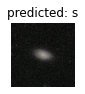

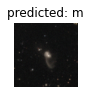

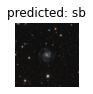

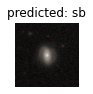

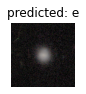

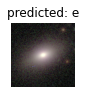

In [20]:
visualize_model(model_ft)

In [21]:
# Shutdown NVML
pynvml.nvmlShutdown()

## Graficar los Resultados

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

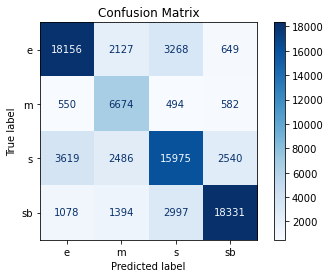

In [23]:
# Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Plotting loss and accuracy curves
def plot_metrics(results_df, metric_name, ylabel, title):
    plt.figure(figsize=(10, 6))
    for phase in ['train', 'validation']:
        phase_data = results_df[results_df['Phase'] == phase]
        plt.plot(phase_data['Epoch'], phase_data[metric_name], label=f'{phase.capitalize()} {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
# Read results and plot
results_df = pd.read_csv('training_results.csv')

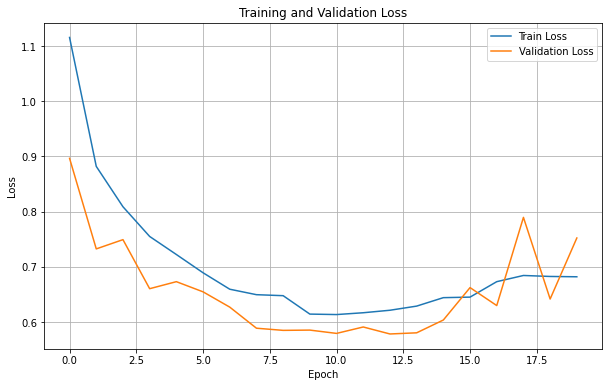

In [26]:
plot_metrics(results_df, 'Loss', 'Loss', 'Training and Validation Loss')

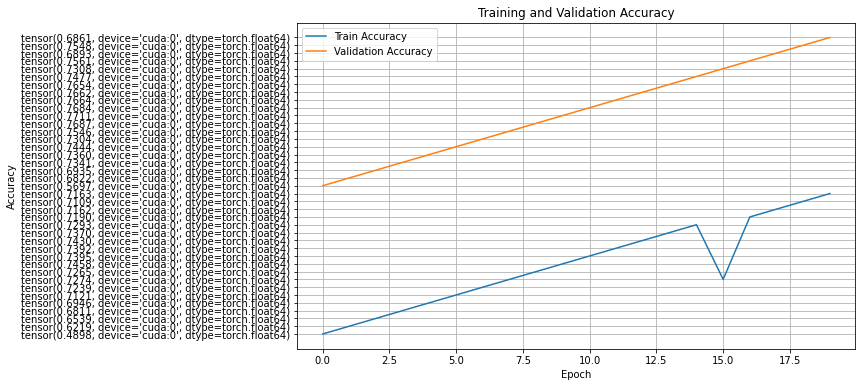

In [27]:
plot_metrics(results_df, 'Accuracy', 'Accuracy', 'Training and Validation Accuracy')

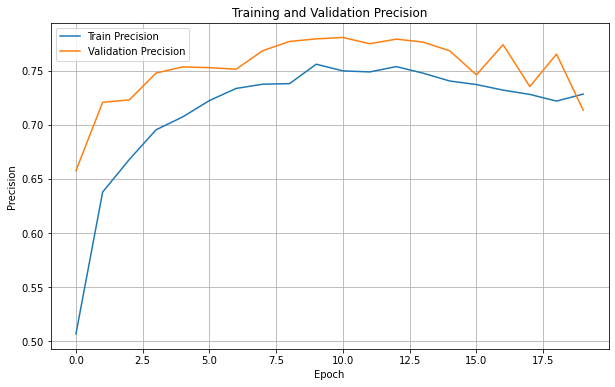

In [28]:
plot_metrics(results_df, 'Precision', 'Precision', 'Training and Validation Precision')

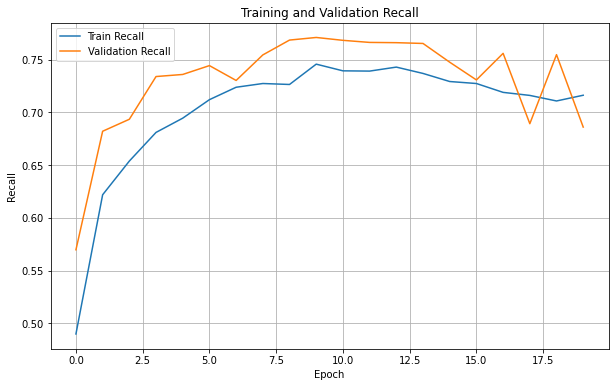

In [29]:
plot_metrics(results_df, 'Recall', 'Recall', 'Training and Validation Recall')

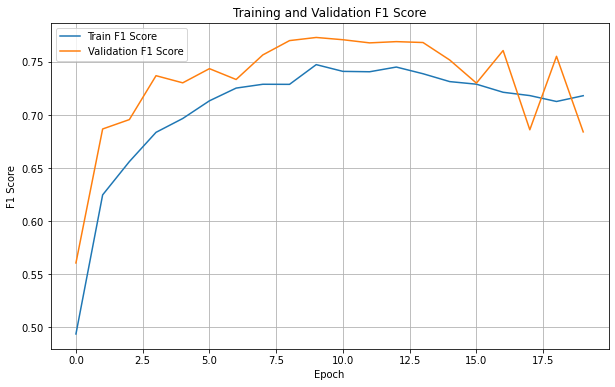

In [30]:
plot_metrics(results_df, 'F1 Score', 'F1 Score', 'Training and Validation F1 Score')

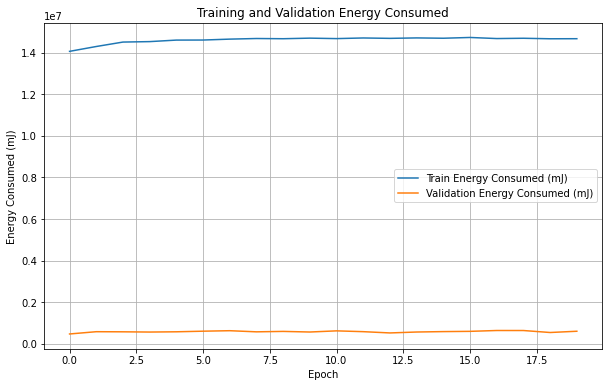

In [31]:
plot_metrics(results_df, 'Energy Consumed (mJ)', 'Energy Consumed (mJ)', 'Training and Validation Energy Consumed')  # <--- Añadir esta línea

## Evaluating on test data


In [38]:
model_ft.eval()
test_labels = []
test_preds = []

In [39]:
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

In [40]:
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
test_cm = confusion_matrix(test_labels, test_preds)
test_acc = accuracy_score(test_labels, test_preds)

In [41]:
print(f'Test Accuracy: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f} F1: {test_f1:.4f}')
print(f'Test Confusion Matrix:\n{test_cm}')

Test Accuracy: 0.7684 Precision: 0.7804 Recall: 0.7684 F1: 0.7698
Test Confusion Matrix:
[[945  79 121  29]
 [ 17 413  16  18]
 [203 115 809  73]
 [ 53  72 141 942]]


In [42]:
print(f'Test Accuracy: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f} F1: {test_f1:.4f}')
print(f'Test Confusion Matrix:\n{test_cm}')

Test Accuracy: 0.7684 Precision: 0.7804 Recall: 0.7684 F1: 0.7698
Test Confusion Matrix:
[[945  79 121  29]
 [ 17 413  16  18]
 [203 115 809  73]
 [ 53  72 141 942]]


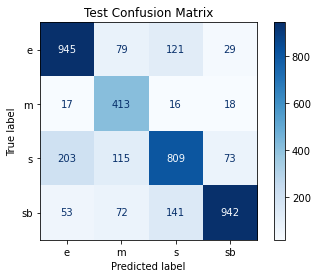

In [43]:
# Plotting the confusion matrix for test data
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

In [44]:
# Visualizing the results in a table
from IPython.display import display
results_df['CO2 Emissions (kg)'] = emissions / len(results_df)
display(results_df)
results_df.to_csv('training_results_resnet101_20.csv', index=False)

,Epoch,Phase,Loss,Accuracy,Precision,Recall,F1 Score,Energy Consumed (mJ),CO2 Emissions (kg)
0,0,train,1.115359,"tensor(0.4898, device='cuda:0', dtype=torch.fl...",0.506648,0.489825,0.493829,14067901,0.001086
1,0,validation,0.896492,"tensor(0.5697, device='cuda:0', dtype=torch.fl...",0.657561,0.569698,0.560698,467497,0.001086
2,1,train,0.881901,"tensor(0.6219, device='cuda:0', dtype=torch.fl...",0.637828,0.621900,0.624787,14301127,0.001086
3,1,validation,0.732502,"tensor(0.6822, device='cuda:0', dtype=torch.fl...",0.720787,0.682155,0.686851,576804,0.001086
4,2,train,0.808820,"tensor(0.6539, device='cuda:0', dtype=torch.fl...",0.667977,0.653868,0.656102,14514582,0.001086
5,2,validation,0.749248,"tensor(0.6935, device='cuda:0', dtype=torch.fl...",0.723067,0.693524,0.695690,571462,0.001086
6,3,train,0.755015,"tensor(0.6811, device='cuda:0', dtype=torch.fl...",0.695380,0.681058,0.683703,14536351,0.001086
7,3,validation,0.660430,"tensor(0.7341, device='cuda:0', dtype=torch.fl...",0.747847,0.734058,0.737036,560340,0.001086
8,4,train,0.722347,"tensor(0.6946, device='cuda:0', dtype=torch.fl...",0.707326,0.694570,0.696725,14609511,0.001086
9,4,validation,0.673154,"tensor(0.7360, device='cuda:0', dtype=torch.fl...",0.753553,0.736036,0.730308,572405,0.001086


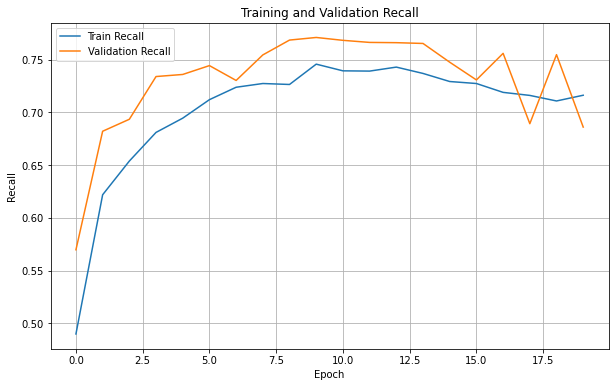

In [37]:
plot_metrics(results_df, 'Recall', 'Recall', 'Training and Validation Recall')